In [54]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation
import datetime
import seaborn as sns
import missingno as msno
import firebase_admin
from firebase_admin import credentials, db
from datetime import datetime  # Untuk konversi timestamp ke human-readable
sns.set_theme(style="whitegrid")
%matplotlib inline 

In [55]:
# Konfigurasi database sumber
source_cred = credentials.Certificate("D:/staklimjerukagung-firebase-adminsdk-kcfma-e091165a9b.json")
firebase_admin.initialize_app(source_cred, {
    'databaseURL': 'https://staklimjerukagung-default-rtdb.asia-southeast1.firebasedatabase.app/'
})

ValueError: The default Firebase app already exists. This means you called initialize_app() more than once without providing an app name as the second argument. In most cases you only need to call initialize_app() once. But if you do want to initialize multiple apps, pass a second argument to initialize_app() to give each app a unique name.

In [ ]:
# Input readable date
start_readable_date = "01-08-2025 00:00:00"  # Format: DD-MM-YYYY HH:MM:SS
end_readable_date = "31-12-2025 23:59:59"  # Format: DD-MM-YYYY HH:MM:SS

# Convert readable date to Unix timestamp
start_timestamp = int(datetime.strptime(start_readable_date, "%d-%m-%Y %H:%M:%S").timestamp())
print(start_timestamp) # Convert to string and print
end_timestamp = int(datetime.strptime(end_readable_date, "%d-%m-%Y %H:%M:%S").timestamp())
print(end_timestamp) # Convert to string and print


1753981200
1767200399


In [ ]:
def fetch_weather_data(station_id, start_ts, end_ts):
    """
    Mengambil data cuaca dari Firebase Realtime Database untuk stasiun dan rentang waktu tertentu.

    Args:
        station_id (str): ID stasiun cuaca (contoh: 'id-03', 'id-04').
        start_ts (int): Timestamp awal (epoch time).
        end_ts (int): Timestamp akhir (epoch time).

    Returns:
        dict: Hasil data dari Firebase, atau None jika tidak ada data.
    """
    try:
        # Membuat path referensi secara dinamis berdasarkan station_id
        ref_path = f'/auto_weather_stat/{station_id}/data'
        ref_data = db.reference(ref_path)

        # Membuat query dengan rentang waktu
        query_data = ref_data.order_by_key().start_at(str(start_ts)).end_at(str(end_ts))

        # Mengambil dan mengembalikan hasil
        results = query_data.get()
        print(f"Data untuk stasiun {station_id} berhasil diambil.")
        return results
    except Exception as e:
        print(f"Terjadi error saat mengambil data untuk {station_id}: {e}")
        return None

# 2. Siapkan daftar ID stasiun yang ingin diambil datanya
station_ids = ['id-03', 'id-05'] # Mudah untuk menambah stasiun baru

# 3. Gunakan loop untuk mengambil data semua stasiun dan simpan hasilnya
all_weather_data = {}
for station in station_ids:
    # Panggil fungsi untuk setiap stasiun
    data = fetch_weather_data(station, start_timestamp, end_timestamp)
    if data:
        all_weather_data[station] = data

Data untuk stasiun id-03 berhasil diambil.
Data untuk stasiun id-05 berhasil diambil.


In [ ]:
def create_weather_dataframe(data_dict, source_name):
    """
    Mengubah dictionary data cuaca menjadi DataFrame Pandas.

    Args:
        data_dict (dict): Dictionary berisi data cuaca yang diambil dari Firebase.
        source_name (str): Nama atau ID sumber data untuk keperluan logging/print.

    Returns:
        pandas.DataFrame: DataFrame yang sudah diformat, atau None jika input kosong.
    """
    # Periksa apakah ada data untuk diproses
    if not data_dict:
        print(f"Tidak ada data dari sumber '{source_name}' untuk diproses.")
        return None

    try:
        # Mengubah data dari dictionary menjadi DataFrame
        # 'orient="index"' menjadikan key dari dictionary sebagai baris awal
        df = pd.DataFrame.from_dict(data_dict, orient='index')

        # Memastikan kolom 'timestamp' ada.
        # Jika 'timestamp' bukan salah satu kolom, berarti ia adalah indeks.
        if 'timestamp' not in df.columns:
            df.index.name = 'timestamp'  # Beri nama pada indeks
            df.reset_index(inplace=True) # Pindahkan indeks menjadi kolom biasa

        print(f"DataFrame untuk sumber '{source_name}' berhasil dibuat.")
        return df
        
    except Exception as e:
        print(f"Gagal membuat DataFrame untuk '{source_name}': {e}")
        return None


# 2. Siapkan dictionary kosong untuk menampung DataFrame yang akan kita buat
weather_dataframes = {}

# 3. Loop melalui setiap item di all_weather_data
#    Gunakan .items() untuk mendapatkan key (nama stasiun) dan value (datanya)
for station_id, raw_data in all_weather_data.items():
    
    # Panggil fungsi baru kita untuk mengubah data mentah menjadi DataFrame
    df = create_weather_dataframe(raw_data, station_id)
    
    # Jika DataFrame berhasil dibuat, simpan ke dalam dictionary kita
    if df is not None:
        weather_dataframes[station_id] = df

# 4. Sekarang semua DataFrame Anda tersimpan rapi di satu tempat
print("\n--- Verifikasi Hasil ---")

DataFrame untuk sumber 'id-03' berhasil dibuat.
DataFrame untuk sumber 'id-05' berhasil dibuat.

--- Verifikasi Hasil ---


In [ ]:
if 'id-03' in weather_dataframes:
    print("\nMenampilkan 5 baris pertama dari DataFrame 'id-03':")
    print(weather_dataframes['id-03'].head())

if 'id-04' in weather_dataframes:
    print("\nMenampilkan 5 baris pertama dari DataFrame 'id-04':")
    print(weather_dataframes['id-04'].head())

if 'id-05' in weather_dataframes:
    print("\nMenampilkan 5 baris pertama dari DataFrame 'id-05':")
    print(weather_dataframes['id-05'].head())


Menampilkan 5 baris pertama dari DataFrame 'id-03':
                 dew  humidity  pressure  temperature     timestamp  volt  \
1753981246  24.27691     93.46   1011.94        25.41  1.753981e+09  4.09   
1753981366  24.24716     93.46   1011.82        25.38  1.753981e+09  4.10   
1753981426  24.23725     93.46   1011.78        25.37  1.753981e+09  4.09   
1753981486  24.22911     93.47   1011.79        25.36  1.753981e+09  4.10   
1753981546  24.23347     93.55   1011.80        25.35  1.753982e+09  4.10   

            rainfall  rainrate  
1753981246       NaN       NaN  
1753981366       NaN       NaN  
1753981426       NaN       NaN  
1753981486       NaN       NaN  
1753981546       NaN       NaN  

Menampilkan 5 baris pertama dari DataFrame 'id-05':
                 dew  humidity  pressure  rainfall  rainrate  temperature  \
1753981211  24.62436  91.35828   1011.34       0.0       0.0     26.14824   
1753981271  24.60573  91.34303   1011.37       0.0       0.0     26.13222   
17

In [ ]:
def convert_timestamp_to_int(df, column_name='timestamp'):
    """
    Mengubah tipe data kolom tertentu dalam DataFrame menjadi integer.

    Args:
        df (pd.DataFrame): DataFrame yang akan dimodifikasi.
        column_name (str): Nama kolom yang akan diubah tipenya. Defaultnya adalah 'timestamp'.

    Returns:
        pd.DataFrame: DataFrame yang telah dimodifikasi, atau DataFrame asli jika kolom tidak ditemukan.
    """
    # Periksa apakah input adalah DataFrame yang valid dan memiliki kolom yang dimaksud
    if isinstance(df, pd.DataFrame) and column_name in df.columns:
        try:
            df[column_name] = df[column_name].astype(int)
            print(f"Kolom '{column_name}' berhasil diubah menjadi tipe integer.")
        except Exception as e:
            print(f"Gagal mengubah tipe data kolom '{column_name}': {e}")
    else:
        # Memberi tahu pengguna jika kolom tidak ada di DataFrame
        print(f"Peringatan: Kolom '{column_name}' tidak ditemukan dalam DataFrame.")
        
    return df



In [ ]:
# Loop melalui setiap DataFrame dan terapkan fungsi konversi
for station_id in weather_dataframes:
    print(f"Memproses DataFrame untuk stasiun: {station_id}")
    weather_dataframes[station_id] = convert_timestamp_to_int(weather_dataframes[station_id])

print("\n--- Memeriksa tipe data SETELAH konversi ---")

Memproses DataFrame untuk stasiun: id-03
Gagal mengubah tipe data kolom 'timestamp': Cannot convert non-finite values (NA or inf) to integer
Memproses DataFrame untuk stasiun: id-05
Kolom 'timestamp' berhasil diubah menjadi tipe integer.

--- Memeriksa tipe data SETELAH konversi ---


In [ ]:
def format_datetime_column(df, column_name='timestamp', target_tz='Asia/Jakarta'):
    """
    Mengonversi kolom timestamp (integer) ke datetime dengan zona waktu tertentu.

    Proses:
    1. Mengubah integer timestamp (detik) menjadi datetime dalam UTC.
    2. Mengonversi datetime dari UTC ke zona waktu target (default: 'Asia/Jakarta').

    Args:
        df (pd.DataFrame): DataFrame yang akan diproses.
        column_name (str): Nama kolom timestamp. Defaultnya 'timestamp'.
        target_tz (str): Zona waktu target. Defaultnya 'Asia/Jakarta'.

    Returns:
        pd.DataFrame: DataFrame yang telah dimodifikasi.
    """
    # Pastikan input adalah DataFrame dan kolomnya ada
    if not isinstance(df, pd.DataFrame) or column_name not in df.columns:
        print(f"Peringatan: Input bukan DataFrame atau kolom '{column_name}' tidak ditemukan.")
        return df

    try:
        # Langkah 1: Konversi dari integer (epoch seconds) ke datetime UTC
        df[column_name] = pd.to_datetime(df[column_name], unit='s', utc=True)
        
        # Langkah 2: Konversi zona waktu dari UTC ke target_tz (WIB)
        df[column_name] = df[column_name].dt.tz_convert(target_tz)
        
        print(f"Kolom '{column_name}' berhasil diformat ke zona waktu {target_tz}.")
    except Exception as e:
        print(f"Gagal memformat kolom '{column_name}': {e}")
        
    return df

In [ ]:
for station_id in weather_dataframes:
    print(f"Memproses DataFrame untuk stasiun: {station_id}")
    weather_dataframes[station_id] = format_datetime_column(weather_dataframes[station_id])

print("\n" + "="*40 + "\n")

Memproses DataFrame untuk stasiun: id-03
Kolom 'timestamp' berhasil diformat ke zona waktu Asia/Jakarta.
Memproses DataFrame untuk stasiun: id-05
Kolom 'timestamp' berhasil diformat ke zona waktu Asia/Jakarta.




In [ ]:
def add_time_features(df, column_name='timestamp'):
    """
    Menambahkan kolom-kolom berbasis waktu (jam, hari, bulan, dll.) ke DataFrame.

    Proses:
    1. Memastikan kolom waktu berformat datetime.
    2. Mengurutkan DataFrame berdasarkan kolom waktu tersebut.
    3. Mengekstrak dan menambahkan kolom 'hour', 'minute', 'day', 'week', 'month', dan 'year'.

    Args:
        df (pd.DataFrame): DataFrame input.
        column_name (str): Nama kolom datetime yang akan diproses.

    Returns:
        pd.DataFrame: DataFrame baru dengan kolom-kolom waktu tambahan.
    """
    if not isinstance(df, pd.DataFrame) or column_name not in df.columns:
        print(f"Peringatan: Input bukan DataFrame atau kolom '{column_name}' tidak ditemukan.")
        return df

    try:
        # Langkah 1: Memastikan kolom 'timestamp' berformat datetime (sebagai pengaman)
        df[column_name] = pd.to_datetime(df[column_name])

        # Langkah 2: Mengurutkan data berdasarkan 'timestamp'
        df = df.sort_values(by=column_name)

        # Langkah 3: Menambahkan kolom-kolom waktu
        df['hour'] = df[column_name].dt.hour
        df['minute'] = df[column_name].dt.minute
        df['day'] = df[column_name].dt.day
        df['week'] = df[column_name].dt.isocalendar().week.astype(int) # .isocalendar() menghasilkan object kompleks
        df['month'] = df[column_name].dt.month
        df['year'] = df[column_name].dt.year
        
        print(f"Fitur waktu berhasil ditambahkan ke DataFrame.")
    except Exception as e:
        print(f"Gagal menambahkan fitur waktu: {e}")
        
    return df

In [ ]:
for station_id in weather_dataframes:
    print(f"--- Memproses DataFrame untuk stasiun: {station_id} ---")
    weather_dataframes[station_id] = add_time_features(weather_dataframes[station_id])

print("\n" + "="*50 + "\n")

# Verifikasi hasil dari dictionary
print("Hasil akhir untuk 'id-03' dari dictionary:")
print(weather_dataframes['id-03'].head())

--- Memproses DataFrame untuk stasiun: id-03 ---
Gagal menambahkan fitur waktu: cannot convert NA to integer
--- Memproses DataFrame untuk stasiun: id-05 ---
Fitur waktu berhasil ditambahkan ke DataFrame.


Hasil akhir untuk 'id-03' dari dictionary:
                 dew  humidity  pressure  temperature  \
1753981246  24.27691     93.46   1011.94        25.41   
1753981366  24.24716     93.46   1011.82        25.38   
1753981426  24.23725     93.46   1011.78        25.37   
1753981486  24.22911     93.47   1011.79        25.36   
1753981546  24.23347     93.55   1011.80        25.35   

                           timestamp  volt  rainfall  rainrate  hour  minute  \
1753981246 2025-08-01 00:00:46+07:00  4.09       NaN       NaN   0.0     0.0   
1753981366 2025-08-01 00:02:46+07:00  4.10       NaN       NaN   0.0     2.0   
1753981426 2025-08-01 00:03:46+07:00  4.09       NaN       NaN   0.0     3.0   
1753981486 2025-08-01 00:04:46+07:00  4.10       NaN       NaN   0.0     4.0   
1753981

In [ ]:
# Mengekstrak setiap DataFrame ke variabel terpisah
cuaca1 = weather_dataframes['id-03']
#cuaca2 = weather_dataframes['id-04']
cuaca3 = weather_dataframes['id-05']

=== Informasi Missing Values dalam cuaca3 ===

dew                 0
humidity            0
pressure            0
temperature         0
timestamp           1
volt                1
rainfall       156568
rainrate       156568
hour                1
minute              1
day                 1
dtype: int64


=== Persentase Missing Values ===

dew             0.000000
humidity        0.000000
pressure        0.000000
temperature     0.000000
timestamp       0.000639
volt            0.000639
rainfall       99.995529
rainrate       99.995529
hour            0.000639
minute          0.000639
day             0.000639
dtype: float64


=== Visualisasi Missing Values ===


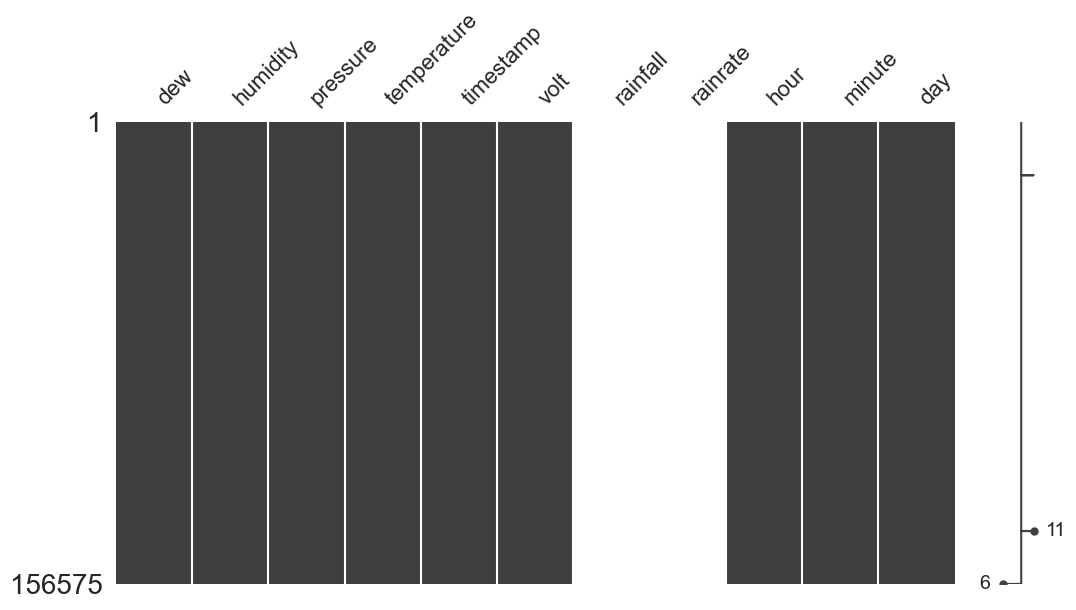


=== Baris dengan Nilai Null ===
Jumlah baris dengan null: 156569

Contoh baris dengan null:
                 dew  humidity  pressure  temperature  \
1753981246  24.27691     93.46   1011.94        25.41   
1753981366  24.24716     93.46   1011.82        25.38   
1753981426  24.23725     93.46   1011.78        25.37   
1753981486  24.22911     93.47   1011.79        25.36   
1753981546  24.23347     93.55   1011.80        25.35   
1753981606  24.26043     93.59   1011.86        25.37   
1753981666  24.21898     93.58   1011.77        25.33   
1753981726  24.21898     93.58   1011.75        25.33   
1753981786  24.20728     93.57   1011.75        25.32   
1753981846  24.21898     93.58   1011.74        25.33   

                           timestamp  volt  rainfall  rainrate  hour  minute  \
1753981246 2025-08-01 00:00:46+07:00  4.09       NaN       NaN   0.0     0.0   
1753981366 2025-08-01 00:02:46+07:00  4.10       NaN       NaN   0.0     2.0   
1753981426 2025-08-01 00:03:46+07:00  4

In [ ]:
# Mengecek nilai null dalam dataframe cuaca3
print("=== Informasi Missing Values dalam cuaca3 ===\n")
print(cuaca1.isnull().sum())
print("\n" + "="*50 + "\n")

# Menampilkan persentase missing values
print("=== Persentase Missing Values ===\n")
missing_percentage = (cuaca1.isnull().sum() / len(cuaca1)) * 100
print(missing_percentage)
print("\n" + "="*50 + "\n")

# Visualisasi missing values menggunakan missingno
print("=== Visualisasi Missing Values ===")
msno.matrix(cuaca1, figsize=(12, 6))
plt.show()

# Menampilkan baris-baris yang mengandung nilai null
print("\n=== Baris dengan Nilai Null ===")
null_rows = cuaca1[cuaca1.isnull().any(axis=1)]
print(f"Jumlah baris dengan null: {len(null_rows)}")
print("\nContoh baris dengan null:")
print(null_rows.head(10))

=== Informasi Missing Values dalam cuaca3 ===

dew             0
humidity        0
pressure        0
rainfall       71
rainrate       71
temperature     0
timestamp       0
volt            0
hour            0
minute          0
day             0
week            0
month           0
year            0
dtype: int64


=== Persentase Missing Values ===

dew            0.00000
humidity       0.00000
pressure       0.00000
rainfall       0.04525
rainrate       0.04525
temperature    0.00000
timestamp      0.00000
volt           0.00000
hour           0.00000
minute         0.00000
day            0.00000
week           0.00000
month          0.00000
year           0.00000
dtype: float64


=== Visualisasi Missing Values ===


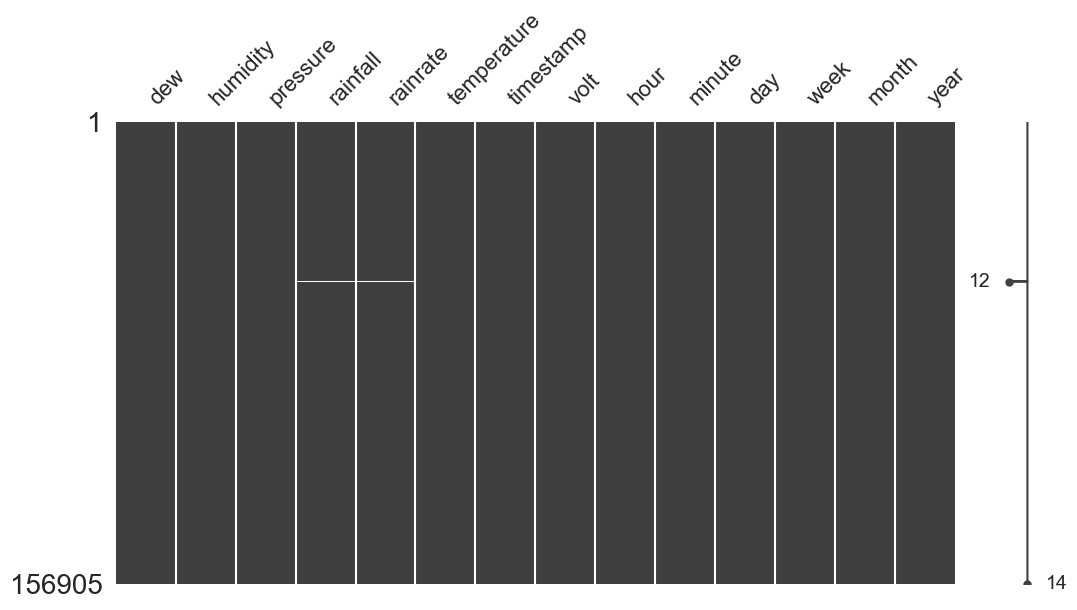


=== Baris dengan Nilai Null ===
Jumlah baris dengan null: 71

Contoh baris dengan null:
                 dew  humidity  pressure  rainfall  rainrate  temperature  \
1757246008  23.99058     83.96  1013.427       NaN       NaN        26.94   
1757246068  23.85299     83.27  1013.431       NaN       NaN        26.94   
1757246128  23.83768     83.34  1013.452       NaN       NaN        26.91   
1757246188  23.90136     83.61  1013.442       NaN       NaN        26.92   
1757246248  23.88361     83.57  1013.464       NaN       NaN        26.91   
1757246308  23.92197     83.91  1013.455       NaN       NaN        26.88   
1757246368  23.95374     84.07  1013.456       NaN       NaN        26.88   
1757246428  24.02284     84.32  1013.469       NaN       NaN        26.90   
1757246488  24.01071     84.16  1013.480       NaN       NaN        26.92   
1757246548  23.98718     84.14  1013.476       NaN       NaN        26.90   

                           timestamp     volt  hour  minute  da

In [ ]:
# Mengecek nilai null dalam dataframe cuaca3
print("=== Informasi Missing Values dalam cuaca3 ===\n")
print(cuaca3.isnull().sum())
print("\n" + "="*50 + "\n")

# Menampilkan persentase missing values
print("=== Persentase Missing Values ===\n")
missing_percentage = (cuaca3.isnull().sum() / len(cuaca3)) * 100
print(missing_percentage)
print("\n" + "="*50 + "\n")

# Visualisasi missing values menggunakan missingno
print("=== Visualisasi Missing Values ===")
msno.matrix(cuaca3, figsize=(12, 6))
plt.show()

# Menampilkan baris-baris yang mengandung nilai null
print("\n=== Baris dengan Nilai Null ===")
null_rows = cuaca3[cuaca3.isnull().any(axis=1)]
print(f"Jumlah baris dengan null: {len(null_rows)}")
print("\nContoh baris dengan null:")
print(null_rows.head(10))

In [ ]:
def plot_station_trends(data_dict, column_to_plot, freq='d'):
    """
    Membuat plot tren perbandingan untuk sebuah kolom dari beberapa stasiun cuaca.

    Args:
        data_dict (dict): Dictionary yang berisi {station_id: DataFrame}.
        column_to_plot (str): Nama kolom yang akan di-plot (misal: 'temperature').
        freq (str): Frekuensi untuk pengelompokan data.
                    'd' untuk harian (daily).
                    'h' untuk per jam (hourly).
    """
    # Menentukan label berdasarkan frekuensi
    freq_labels = {
        'd': {'label': 'Harian', 'xlabel': 'Tanggal'},
        'h': {'label': 'Per Jam', 'xlabel': 'Waktu (Jam)'},
        'min': {'label': 'Per Menit', 'xlabel': 'Waktu (Menit)'}
    }
    
    # Pilih label yang sesuai, default ke 'Harian' jika freq tidak dikenali
    selected_freq = freq_labels.get(freq, freq_labels['d'])
    
    # Membuat figure dan axes untuk plot
    plt.figure(figsize=(15, 7))

    # Loop melalui setiap stasiun dalam dictionary
    for station_id, df in data_dict.items():
        if column_to_plot not in df.columns:
            print(f"Peringatan: Kolom '{column_to_plot}' tidak ada di stasiun {station_id}. Dilewati.")
            continue

        temp_df = df.copy()
        
        # Mengelompokkan data berdasarkan frekuensi (harian atau per jam)
        time_group_col = f'time_group_{freq}'
        temp_df[time_group_col] = temp_df['timestamp'].dt.floor(freq)
        trend_data = temp_df.groupby(time_group_col)[column_to_plot].mean().reset_index()

        # Plot data untuk stasiun saat ini
        plt.plot(trend_data[time_group_col], trend_data[column_to_plot], label=station_id, alpha=0.8)

    # Menambahkan detail pada plot
    plt.xlabel(selected_freq['xlabel'])
    plt.ylabel(f"Rata-rata {column_to_plot.capitalize()}")
    plt.title(f"Perbandingan Rata-rata {selected_freq['label']} {column_to_plot.capitalize()} antar Stasiun")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Menampilkan plot
    plt.show()

Menampilkan plot perbandingan per menit...


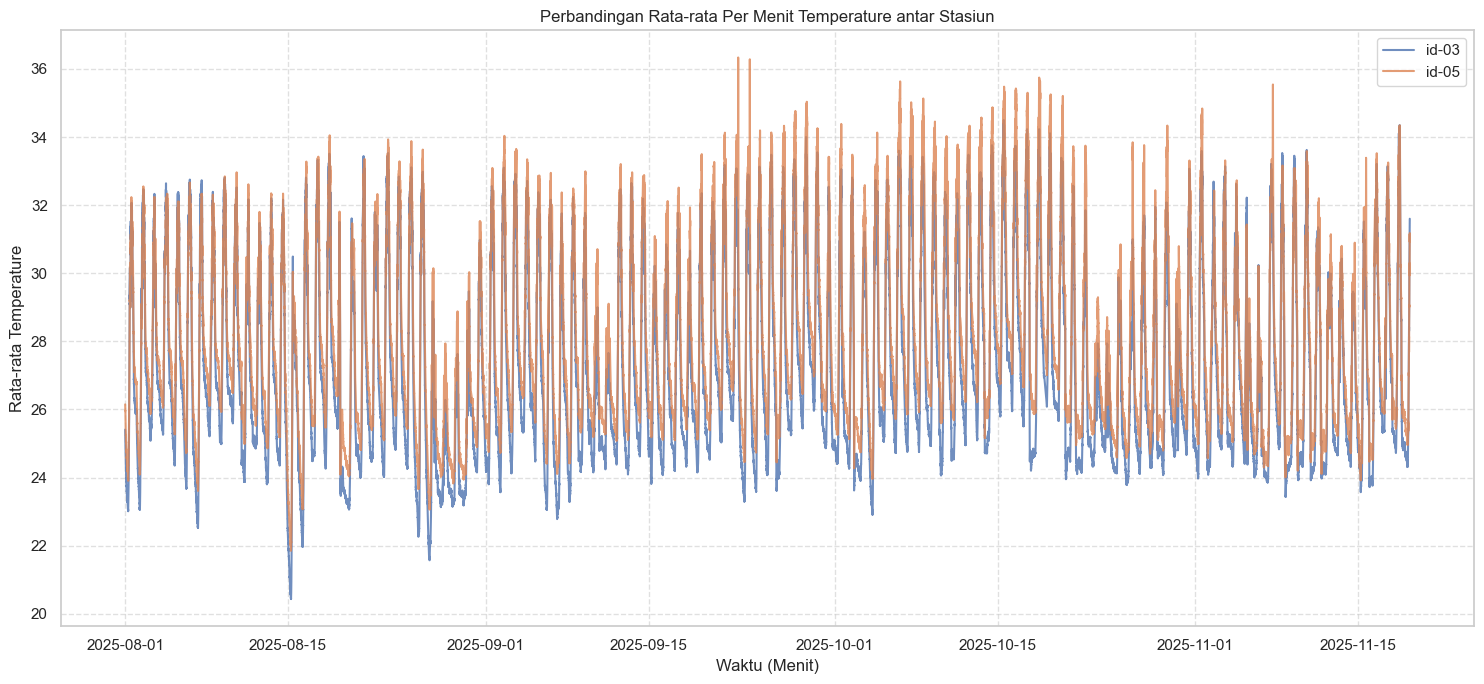

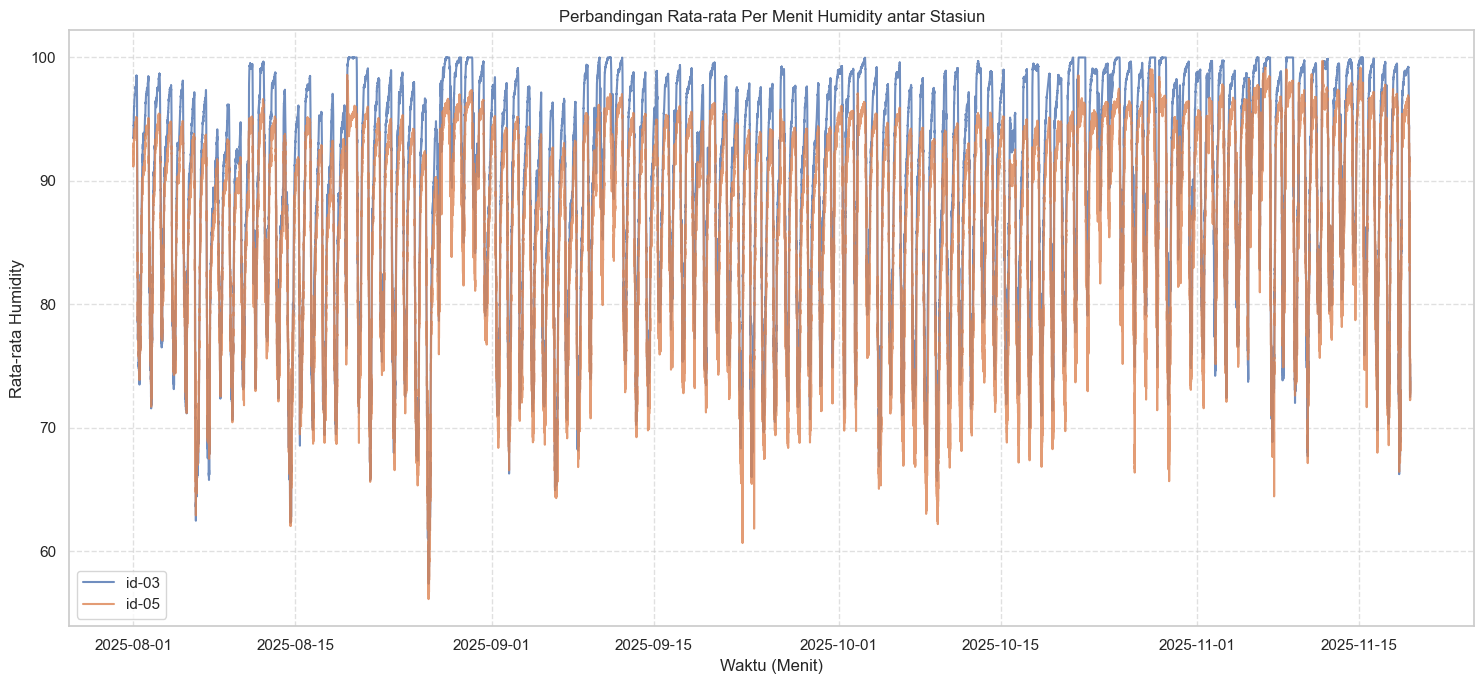

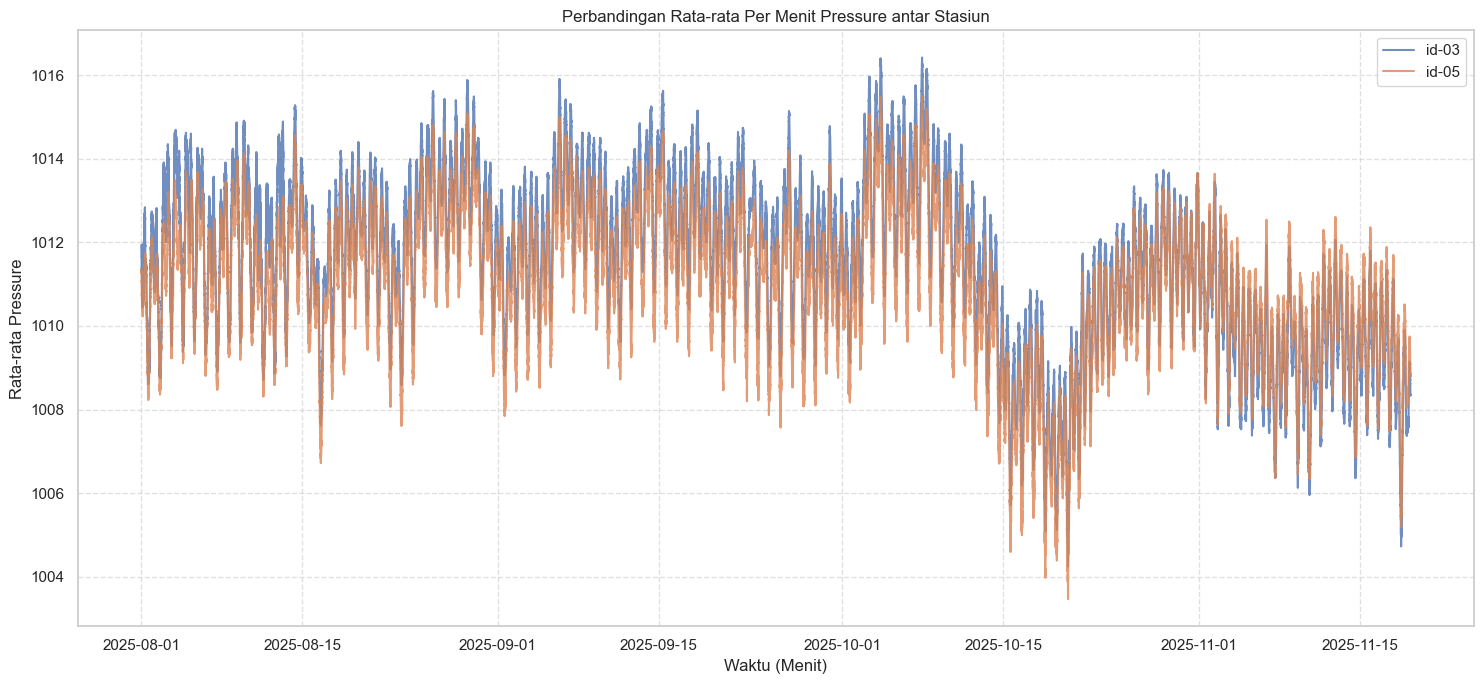

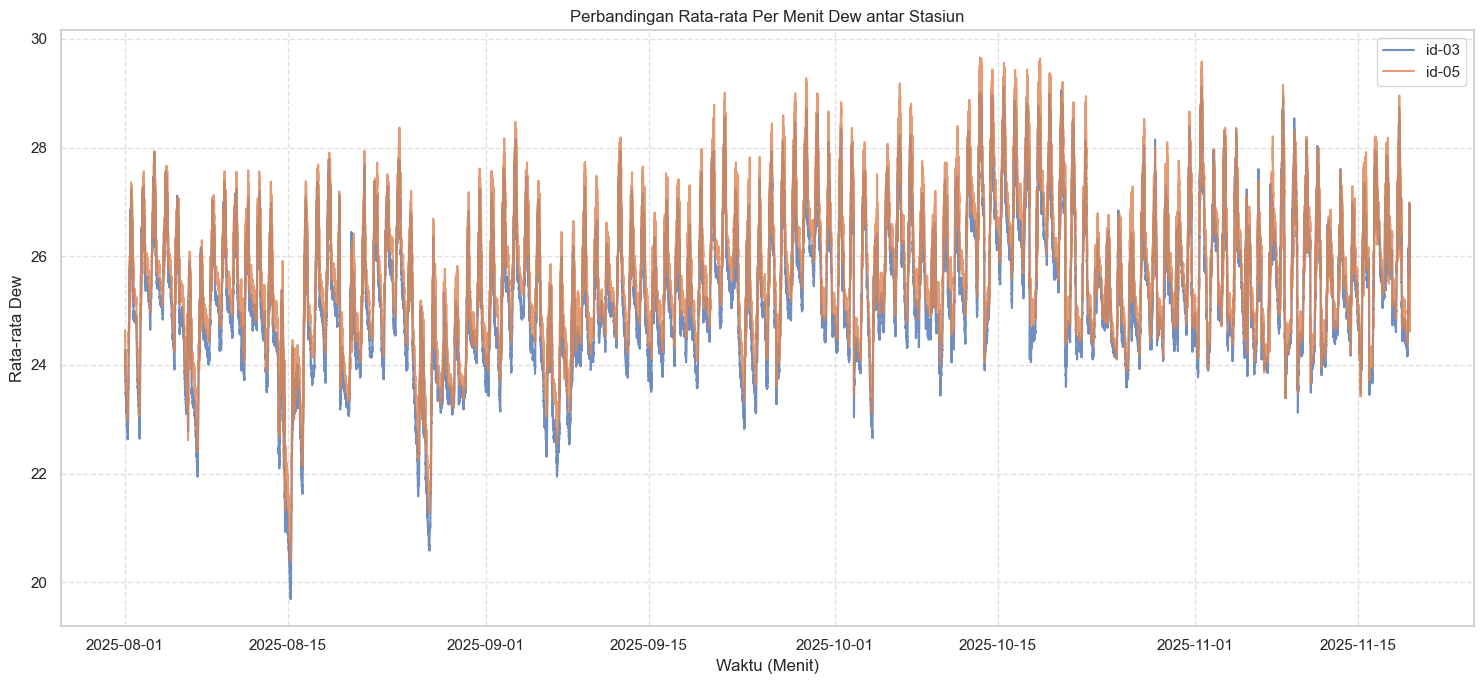

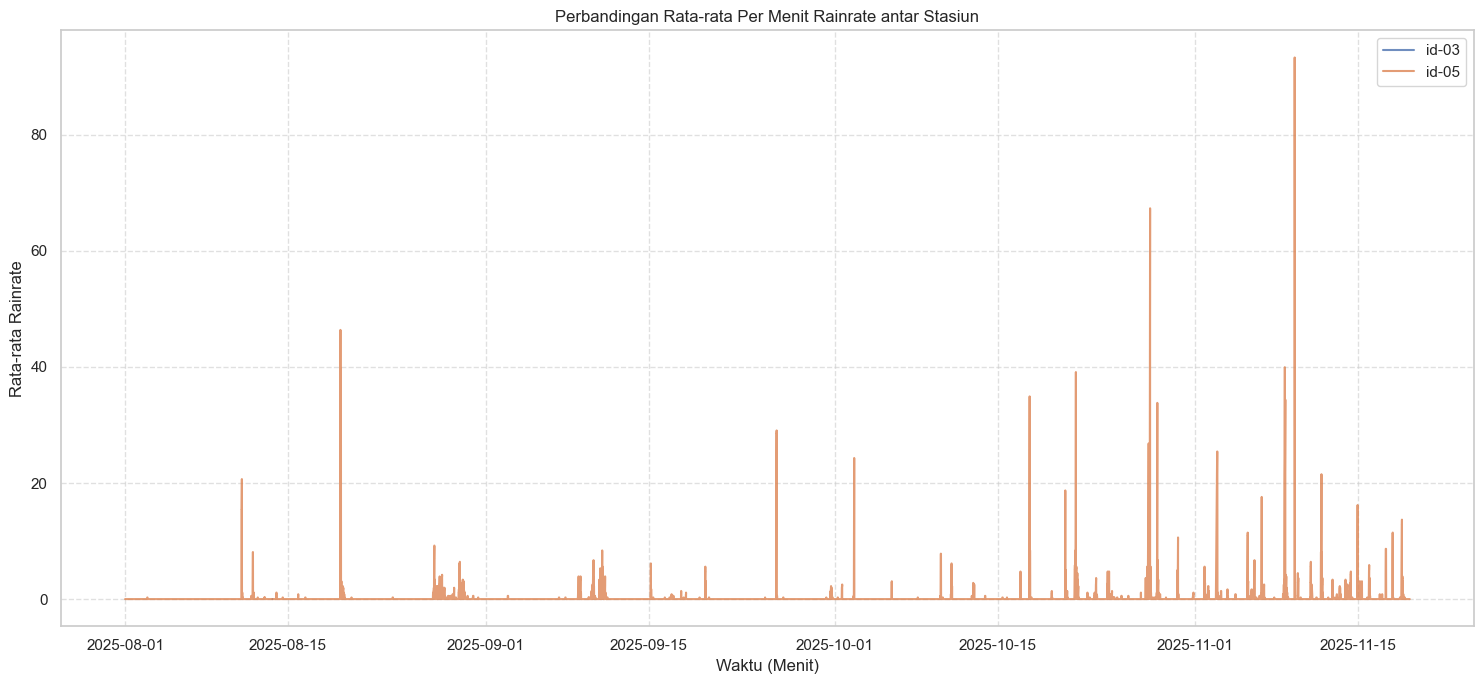

Menampilkan plot perbandingan per jam...


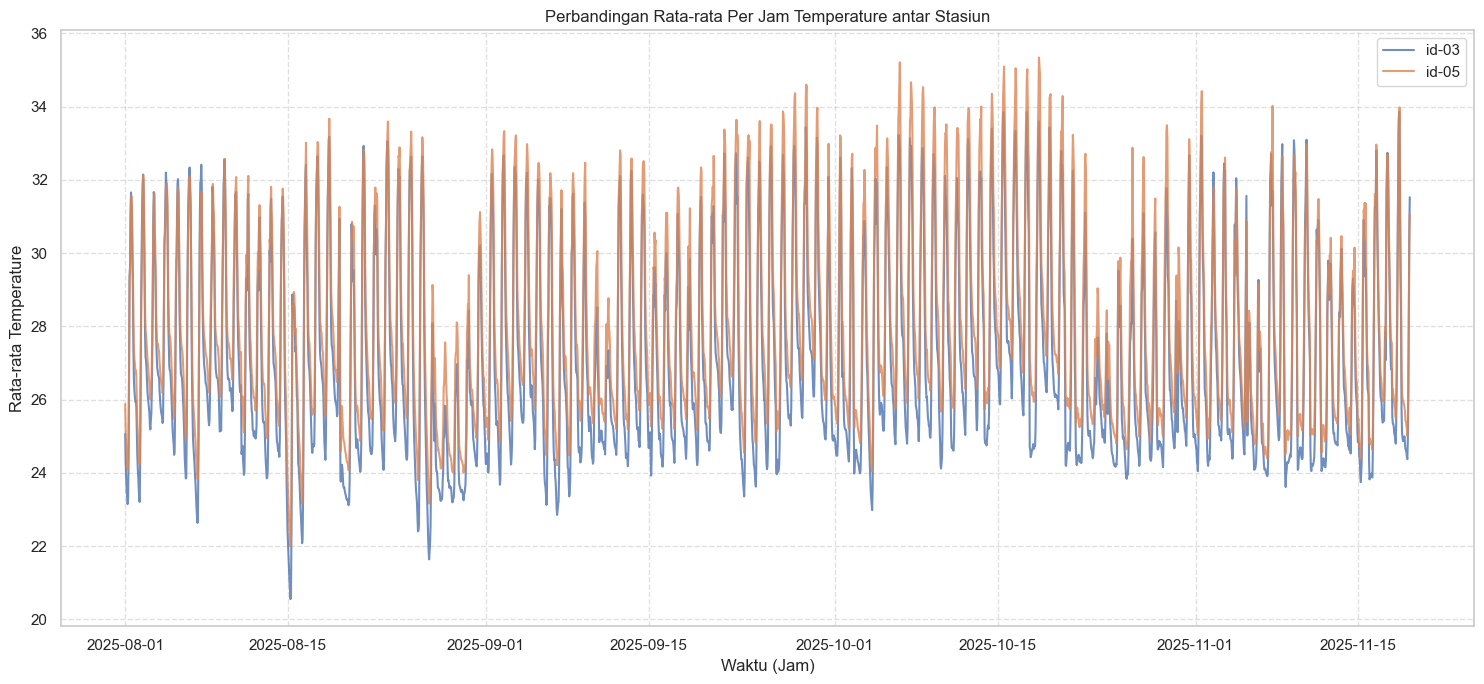

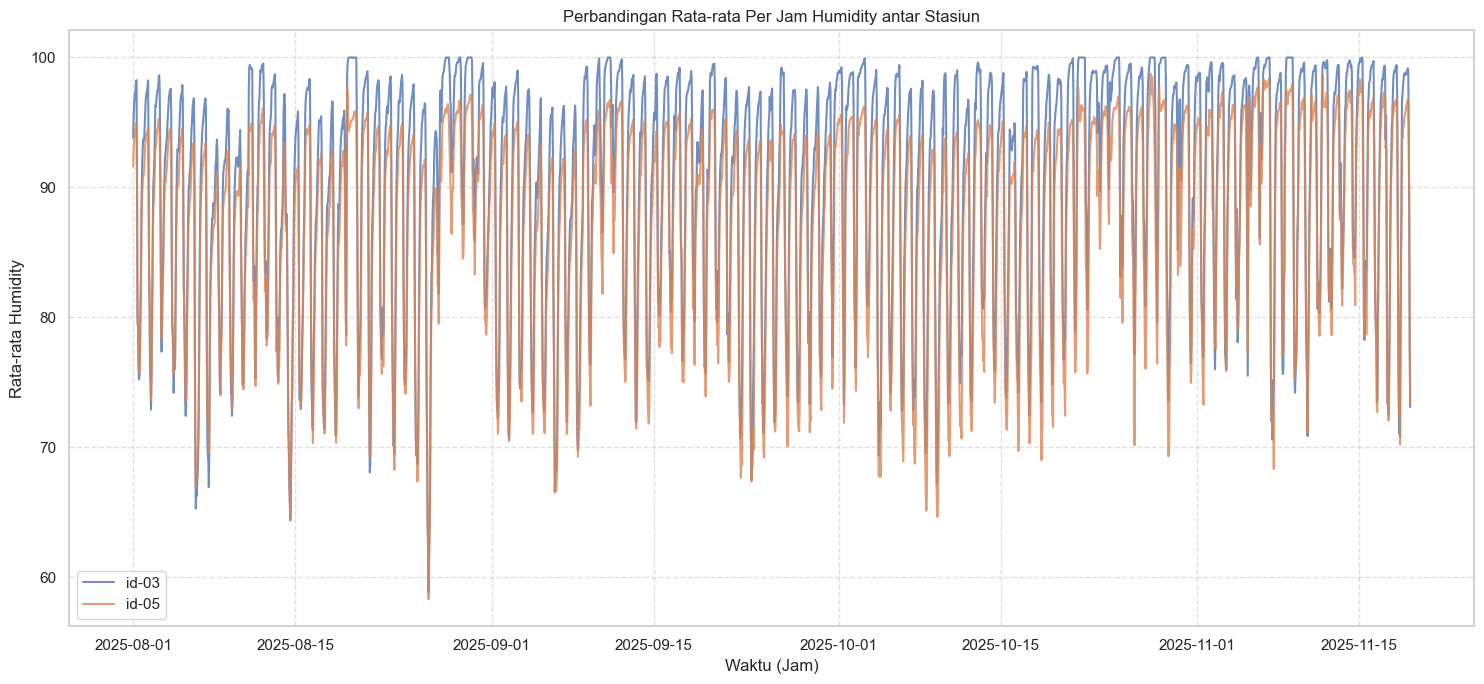

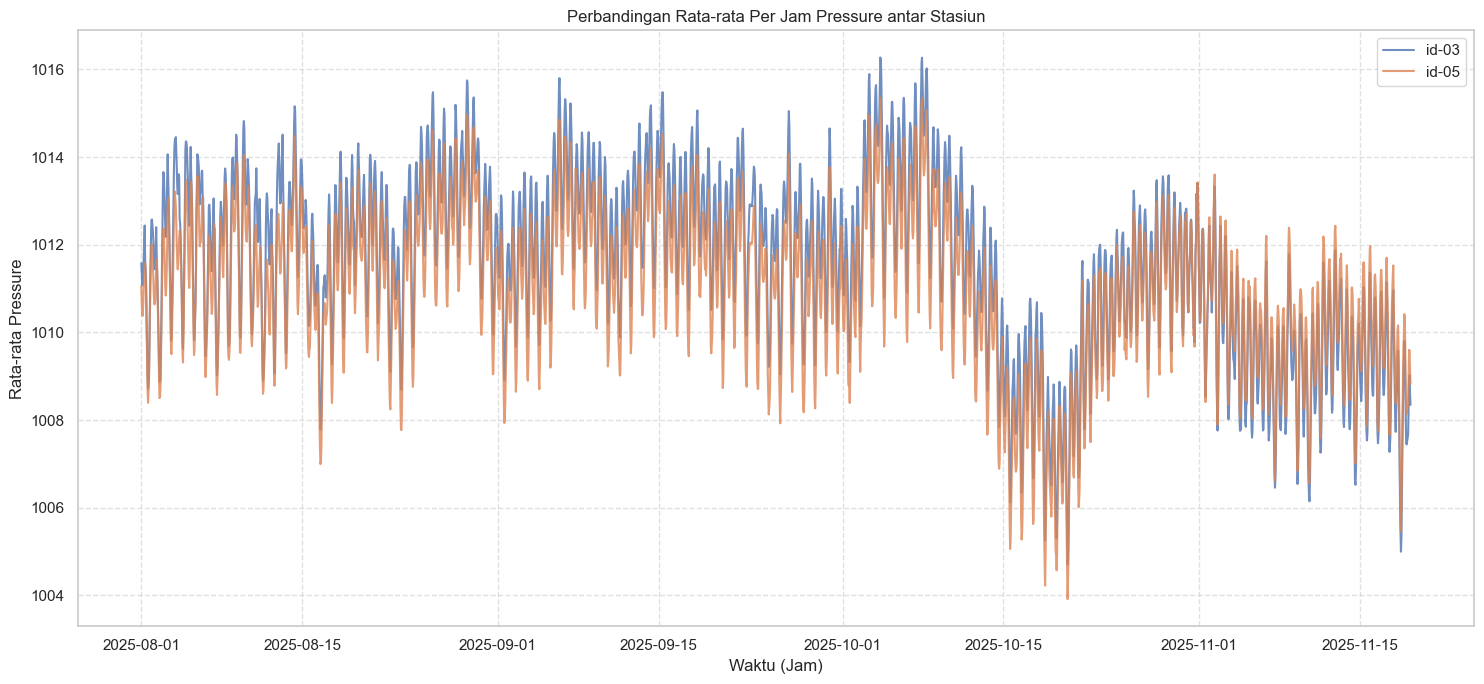

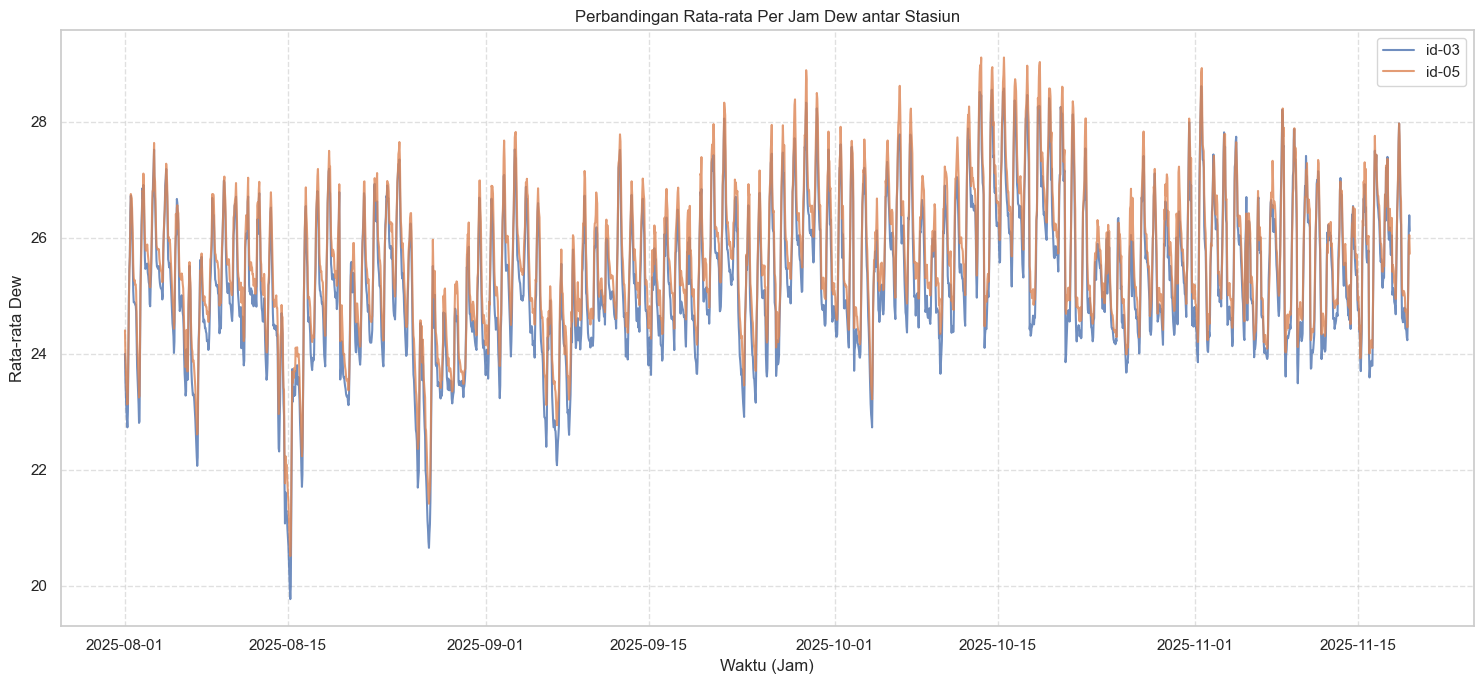

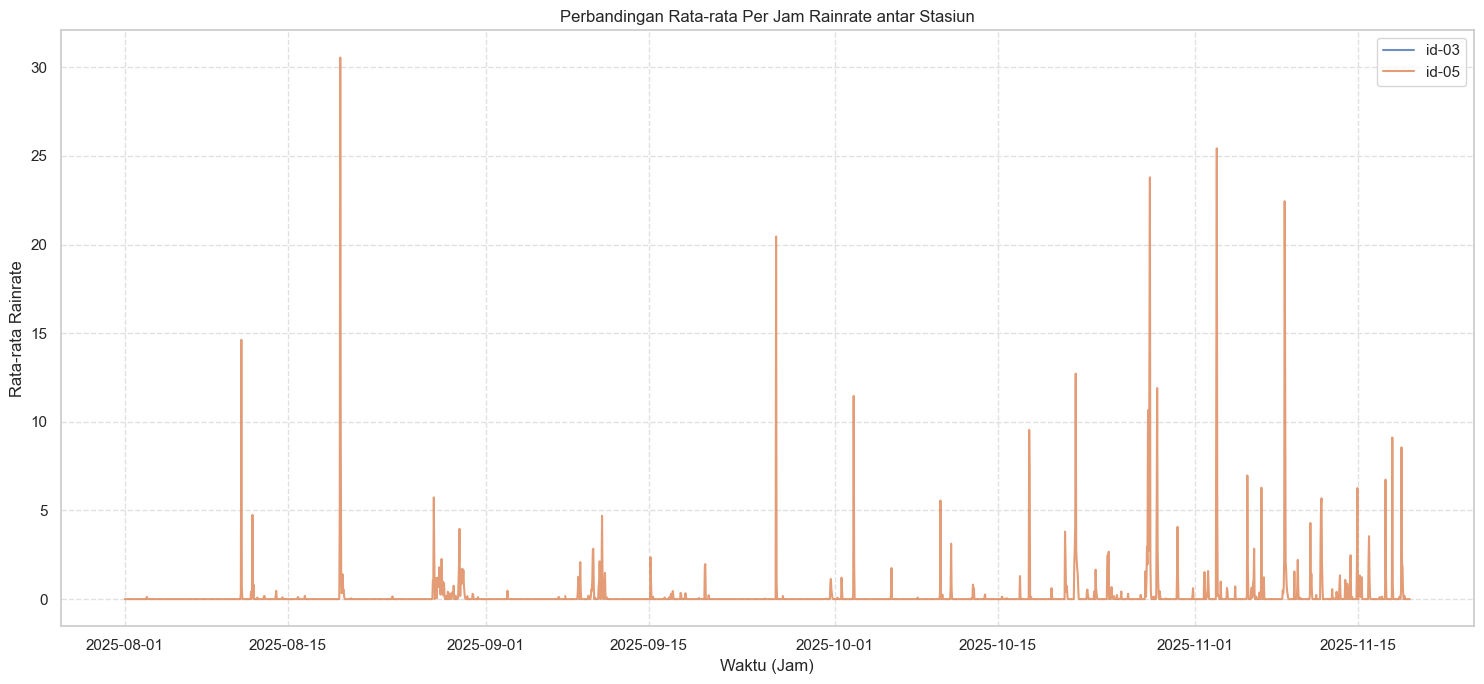


Menampilkan plot perbandingan per hari...


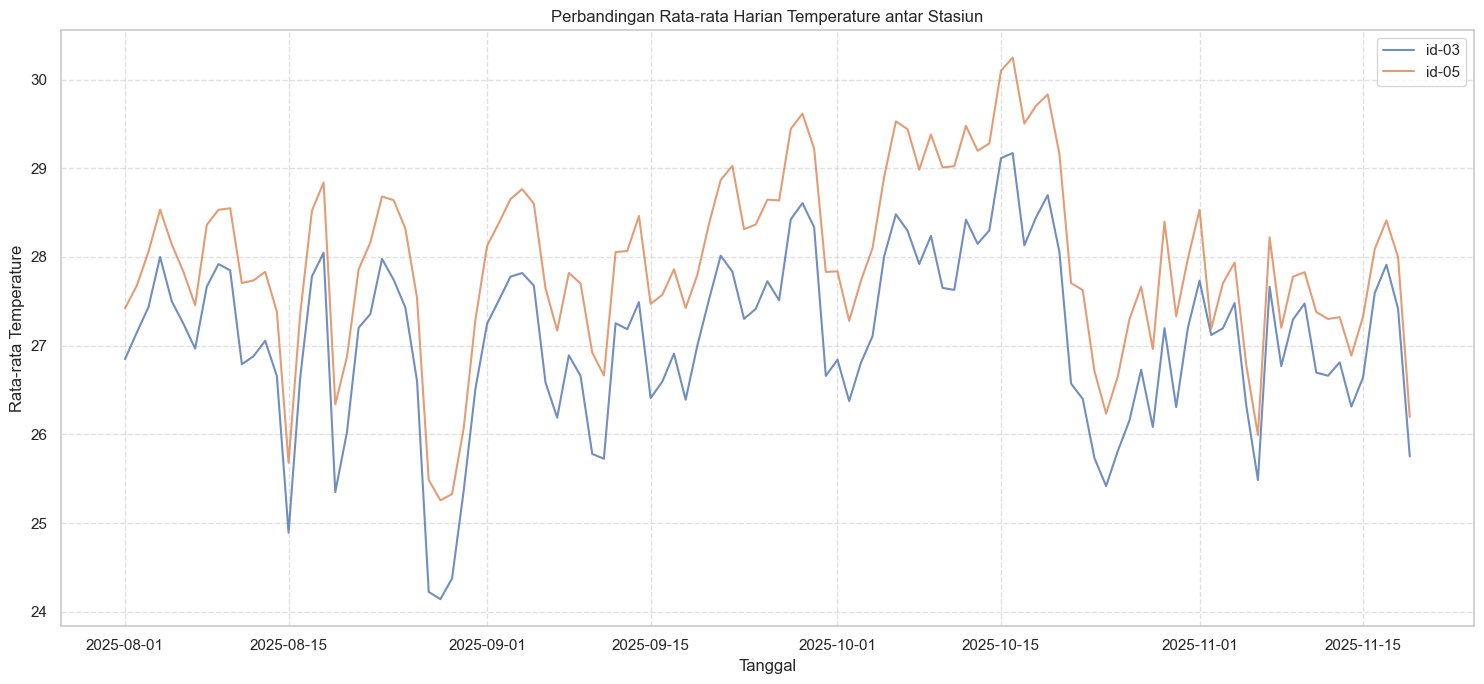

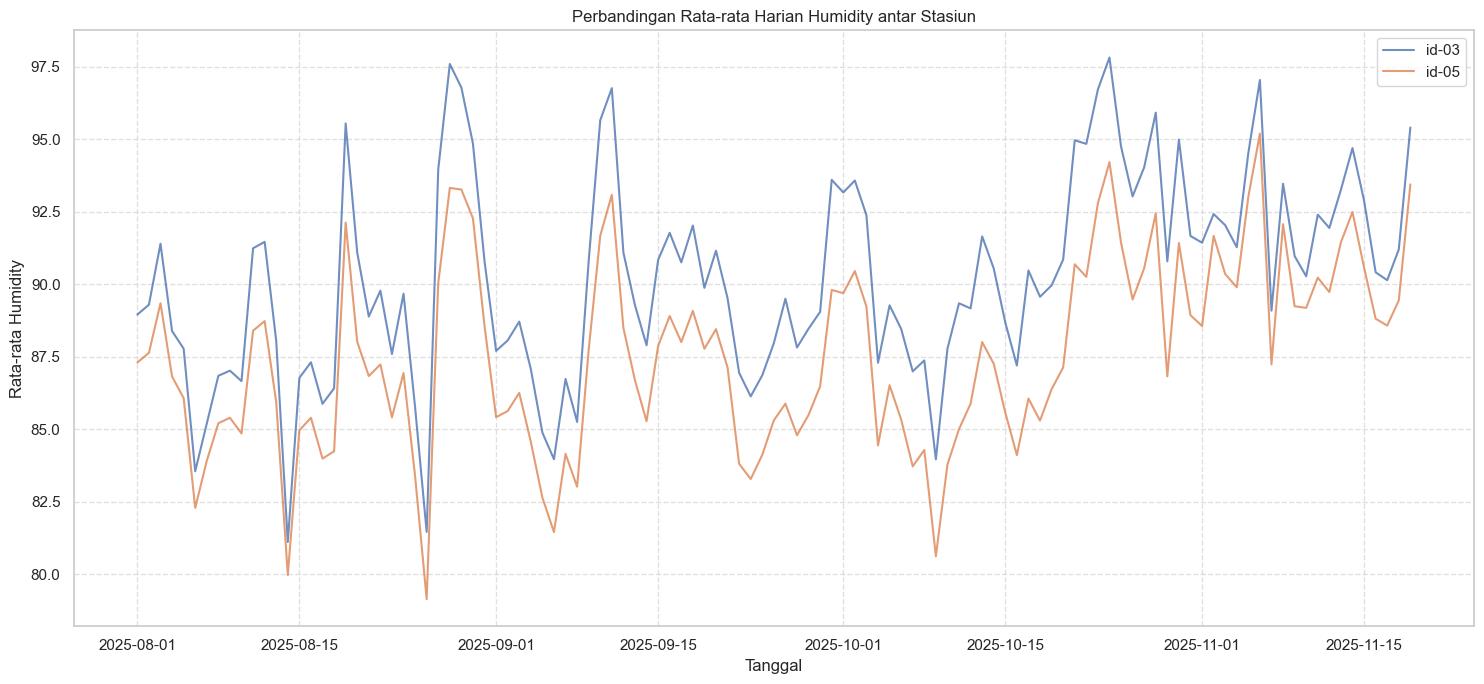

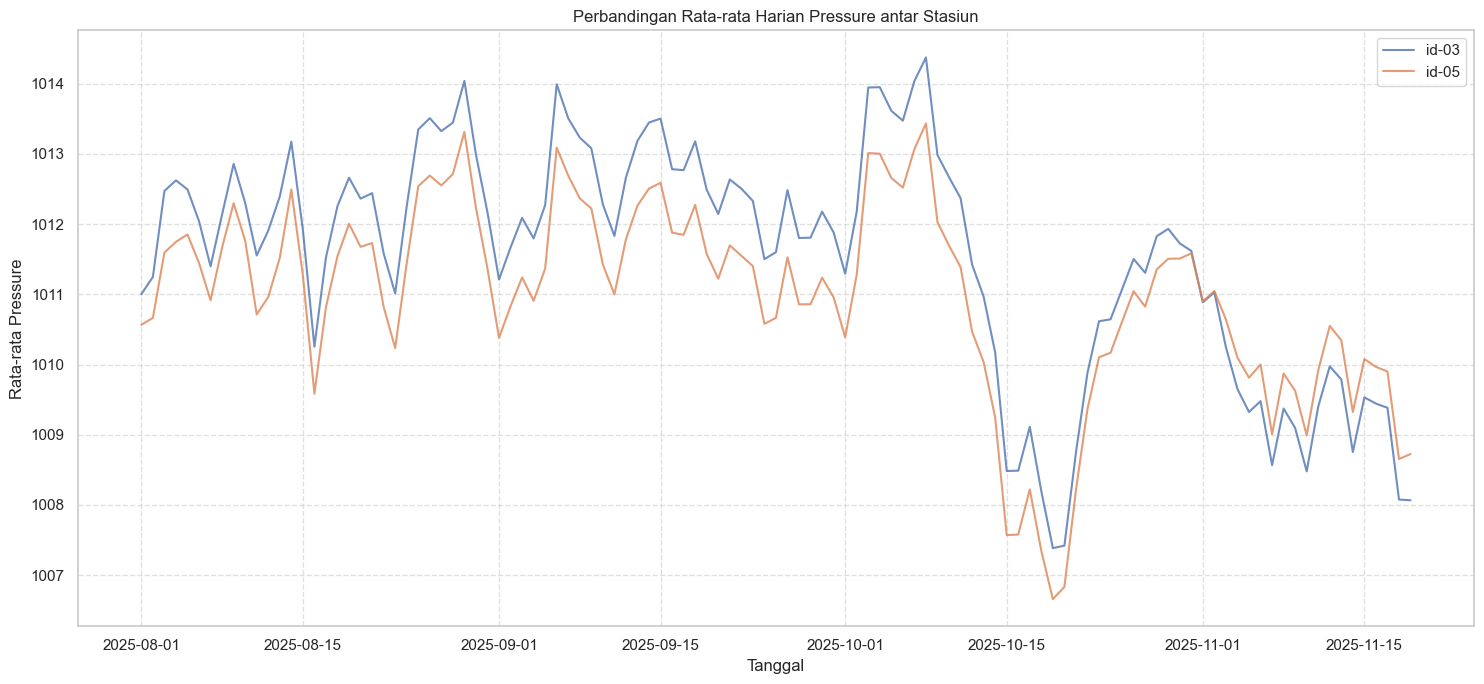

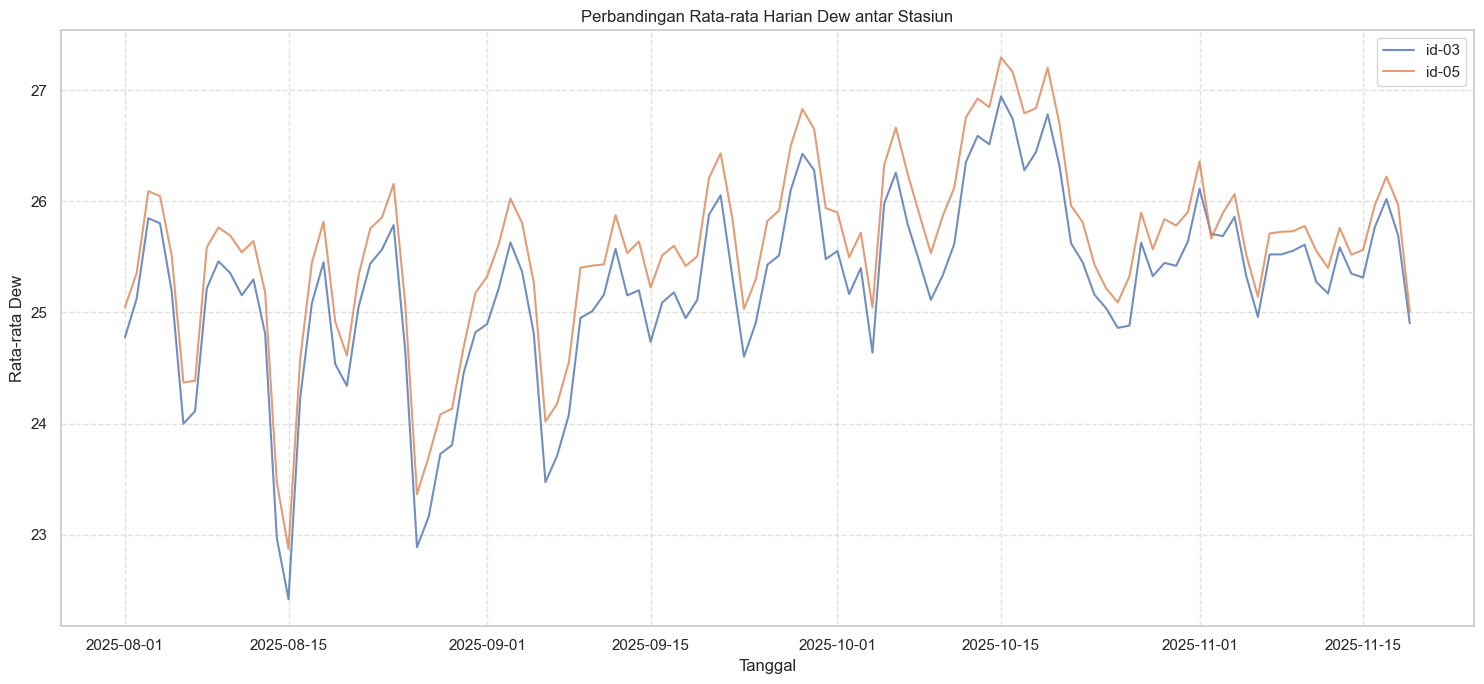

In [ ]:
# Asumsi Anda sudah memiliki dictionary 'weather_dataframes'
print("Menampilkan plot perbandingan per menit...")
plot_station_trends(weather_dataframes, 'temperature', freq='min')
plot_station_trends(weather_dataframes, 'humidity', freq='min')
plot_station_trends(weather_dataframes, 'pressure', freq='min')
plot_station_trends(weather_dataframes, 'dew', freq='min')
plot_station_trends(weather_dataframes, 'rainrate', freq='min')
# --- 1. Membuat Plot Rata-rata PER JAM ---
# Cukup atur freq='h'
print("Menampilkan plot perbandingan per jam...")
plot_station_trends(weather_dataframes, 'temperature', freq='h')
plot_station_trends(weather_dataframes, 'humidity', freq='h')
plot_station_trends(weather_dataframes, 'pressure', freq='h')
plot_station_trends(weather_dataframes, 'dew', freq='h')
plot_station_trends(weather_dataframes, 'rainrate', freq='h')


# --- 2. Membuat Plot Rata-rata PER HARI ---
# Gunakan nilai default freq='d' atau tulis secara eksplisit
print("\nMenampilkan plot perbandingan per hari...")
plot_station_trends(weather_dataframes, 'temperature', freq='d')
plot_station_trends(weather_dataframes, 'humidity', freq='d')
plot_station_trends(weather_dataframes, 'pressure', freq='d')
plot_station_trends(weather_dataframes, 'dew', freq='d')

In [ ]:
# Perhitungan curah hujan harian dan suhu rata-rata untuk stasiun 'id-05' (cuaca3)
# Sesuai permintaan, logika berikut akan:
# 1. Mencari nilai 'rainrate' maksimum untuk setiap jam.
# 2. Menjumlahkan nilai-nilai maksimum per jam tersebut untuk mendapatkan total harian.
# 3. Menghitung suhu rata-rata harian.

# Salin dataframe untuk menghindari perubahan pada data asli
df_hujan = cuaca3.copy()

# Atur 'timestamp' sebagai indeks untuk mempermudah operasi time series
df_hujan.set_index('timestamp', inplace=True)

df_hujan.head(10)

,dew,humidity,pressure,rainfall,rainrate,temperature,volt,hour,minute,day,week,month,year
timestamp,,,,,,,,,,,,,
2025-08-01 00:00:11+07:00,24.62436,91.35828,1011.34,0.0,0.0,26.14824,3.95875,0,0,1,31,8,2025
2025-08-01 00:01:11+07:00,24.60573,91.34303,1011.37,0.0,0.0,26.13222,3.95000,0,1,1,31,8,2025
2025-08-01 00:02:11+07:00,24.58146,91.32586,1011.34,0.0,0.0,26.11086,3.94125,0,2,1,31,8,2025
2025-08-01 00:03:11+07:00,24.58143,91.35447,1011.33,0.0,0.0,26.10551,3.94875,0,3,1,31,8,2025
2025-08-01 00:04:11+07:00,24.57535,91.43649,1011.31,0.0,0.0,26.08415,3.95000,0,4,1,31,8,2025
2025-08-01 00:05:11+07:00,24.57701,91.37354,1011.31,0.0,0.0,26.09750,3.95125,0,5,1,31,8,2025
2025-08-01 00:06:11+07:00,24.63513,91.60433,1011.30,0.0,0.0,26.11353,3.95125,0,6,1,31,8,2025
2025-08-01 00:07:11+07:00,24.58234,91.47463,1011.29,0.0,0.0,26.08415,3.94000,0,7,1,31,8,2025
2025-08-01 00:08:11+07:00,24.59306,91.48989,1011.26,0.0,0.0,26.09216,3.97625,0,8,1,31,8,2025


In [ ]:
# Langkah 1: Resample data untuk mendapatkan nilai 'rainrate' maksimum per jam.
max_per_jam = df_hujan['rainrate'].tz_convert('UTC').resample('h').max()

# Langkah 2: Resample harian (cut-off 00:00 UTC / 07:00 WIB)
curah_hujan_harian = max_per_jam.resample('d').sum()

# Langkah 3: Hitung statistik suhu harian
# Menggunakan UTC agar sinkron dengan periode hujan
suhu_data_utc = df_hujan['temperature'].tz_convert('UTC')
suhu_rata_harian = suhu_data_utc.resample('d').mean()
suhu_maks_harian = suhu_data_utc.resample('d').max()
suhu_mini_harian = suhu_data_utc.resample('d').min()

# Gabungkan ke DataFrame
df_harian = pd.DataFrame({
    'curah_hujan': curah_hujan_harian,
    'rata_suhu': suhu_rata_harian,
    'suhu_maks': suhu_maks_harian,
    'suhu_mini': suhu_mini_harian
})

# Handling NaN
df_harian['curah_hujan'] = df_harian['curah_hujan'].fillna(0)
df_harian['rata_suhu'] = df_harian['rata_suhu'].interpolate(method='linear')
df_harian['suhu_maks'] = df_harian['suhu_maks'].interpolate(method='linear')
df_harian['suhu_mini'] = df_harian['suhu_mini'].interpolate(method='linear')

# Kembalikan index ke WIB
df_harian = df_harian.tz_convert('Asia/Jakarta')

# --- FILTER TANGGAL AGAR RAPI ---
# Menggunakan start_readable_date dan end_readable_date dari input pengguna
# Format asumsi: "DD-MM-YYYY HH:MM:SS"
start_ts = pd.to_datetime(start_readable_date, dayfirst=True).tz_localize('Asia/Jakarta').floor('D')
end_ts = pd.to_datetime(end_readable_date, dayfirst=True).tz_localize('Asia/Jakarta').ceil('D')

# Potong data yang di luar rentang
df_harian = df_harian.loc[(df_harian.index >= start_ts) & (df_harian.index < end_ts)]

print("--- Data Harian Terolah (Final) ---")
print(df_harian)
print("\n" + "="*50 + "\n")

--- Data Harian Terolah (Final) ---
                           curah_hujan  rata_suhu  suhu_maks  suhu_mini
timestamp                                                              
2025-08-01 07:00:00+07:00       0.0000  27.480646   32.23392   24.09209
2025-08-02 07:00:00+07:00       0.5588  28.104842   32.54902   24.58877
2025-08-03 07:00:00+07:00       0.0000  28.081228   32.24193   26.05211
2025-08-04 07:00:00+07:00       0.0000  28.401354   32.33540   25.26704
2025-08-05 07:00:00+07:00       0.0000  28.032310   32.10841   24.71694
...                                ...        ...        ...        ...
2025-11-15 07:00:00+07:00      18.4404  27.342937   33.39017   24.41787
2025-11-16 07:00:00+07:00       2.5146  28.467597   33.52369   25.85985
2025-11-17 07:00:00+07:00      40.5130  28.326019   33.25132   25.44061
2025-11-18 07:00:00+07:00      26.2636  27.843785   34.34348   24.95461
2025-11-19 07:00:00+07:00       0.0000  28.144195   31.17914   25.60883

[111 rows x 4 columns]




In [ ]:
df_harian.tail(10)

,curah_hujan,rata_suhu,suhu_maks,suhu_mini
timestamp,,,,
2025-11-10 07:00:00+07:00,18.1610,27.867031,33.58778,24.45258
2025-11-11 07:00:00+07:00,42.7482,27.378634,32.20187,24.10544
2025-11-12 07:00:00+07:00,5.3086,27.330303,31.14442,25.22163
2025-11-13 07:00:00+07:00,13.6906,27.310871,30.80263,25.10681
2025-11-14 07:00:00+07:00,46.1010,26.687144,30.89609,23.91585
2025-11-15 07:00:00+07:00,18.4404,27.342937,33.39017,24.41787
2025-11-16 07:00:00+07:00,2.5146,28.467597,33.52369,25.85985
2025-11-17 07:00:00+07:00,40.5130,28.326019,33.25132,25.44061
2025-11-18 07:00:00+07:00,26.2636,27.843785,34.34348,24.95461


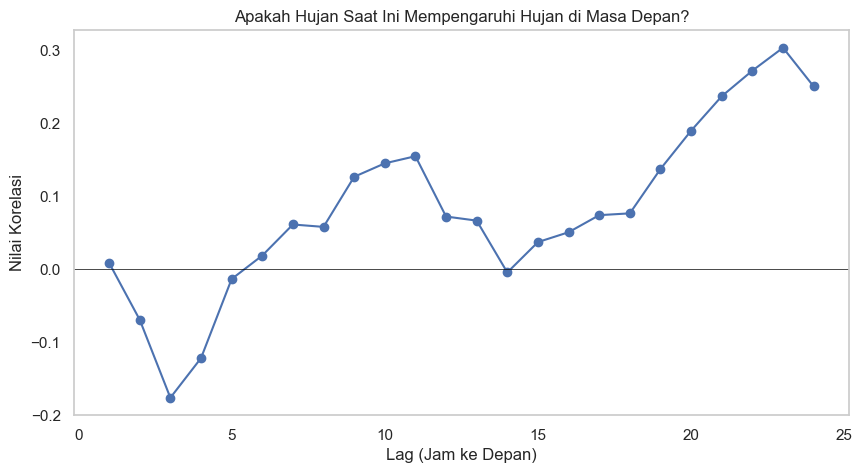

In [ ]:
# Anggap df_hujan punya kolom 'temperature' dan 'rainrate'

hasil_korelasi = []
max_lag = 24 # Cek sampai 48 jam ke depan

for i in range(1, max_lag + 1):
    # Korelasi: Suhu SEKARANG vs Hujan 'i' JAM KEMUDIAN
    # Kita shift hujan ke atas (masa depan ditarik ke sekarang)
    future_rain = df_harian['curah_hujan'].shift(-i)
    
    corr = df_harian['rata_suhu'].corr(future_rain)
    hasil_korelasi.append(corr)
    
# Plot hasilnya
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_lag + 1), hasil_korelasi, marker='o')
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Lag (Jam ke Depan)')
plt.ylabel('Nilai Korelasi')
plt.title('Apakah Hujan Saat Ini Mempengaruhi Hujan di Masa Depan?')
plt.grid()
plt.show()

Text(0.5, 0, 'Lama Hujan (Jam)')

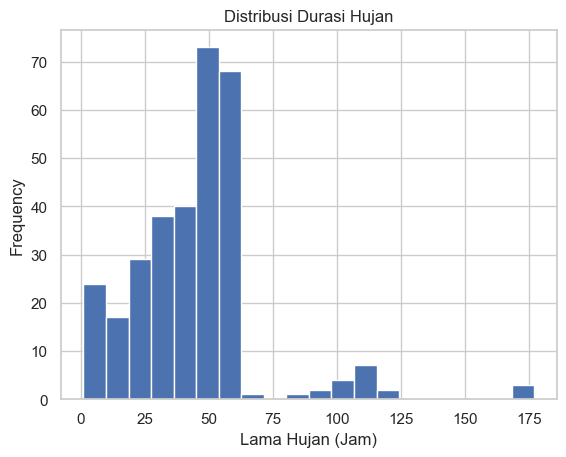

In [ ]:
# Logika untuk mengelompokkan jam hujan berturut-turut
# (Kode agak kompleks, ini logika intinya)
df_hujan['is_rain'] = df_hujan['rainrate'] > 0
# Memberi ID unik untuk setiap blok kejadian hujan
df_hujan['storm_id'] = (df_hujan['is_rain'] != df_hujan['is_rain'].shift()).cumsum()

# Filter hanya yang hujan
badai = df_hujan[df_hujan['is_rain']].groupby('storm_id')

# Hitung durasi setiap badai
durasi_badai = badai.size()  # Dalam jam (karena data per jam)

# Histogram Durasi
durasi_badai.plot(kind='hist', bins=20, title='Distribusi Durasi Hujan')
plt.xlabel('Lama Hujan (Jam)')

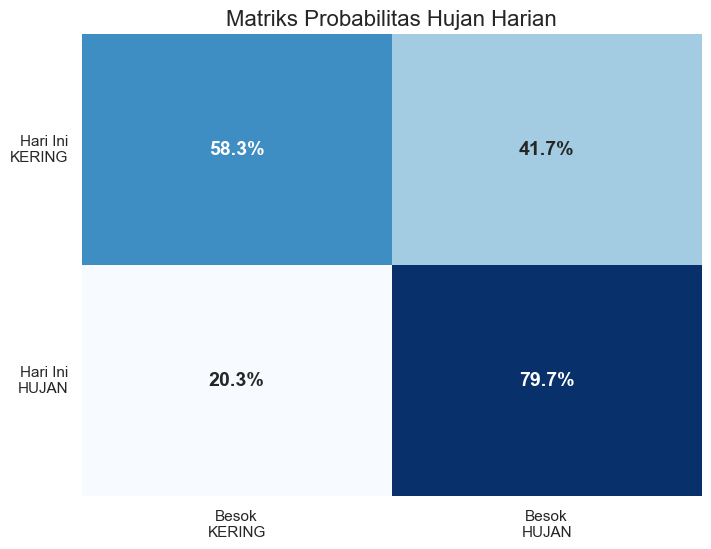

In [56]:
# Siapkan data (Labeling ulang)
plot_data = transisi_harian.copy()
plot_data.index = ['Hari Ini\nKERING', 'Hari Ini\nHUJAN']
plot_data.columns = ['Besok\nKERING', 'Besok\nHUJAN']

plt.figure(figsize=(8, 6))

# Gambar Heatmap
sns.heatmap(plot_data, 
            annot=True,       # Tampilkan angkanya
            fmt=".1%",        # Format angka jadi Persen (contoh: 58.3%)
            cmap="Blues",     # Skala warna Biru (Makin biru = Makin mungkin)
            cbar=False,       # Hilangkan colorbar samping biar bersih
            annot_kws={"size": 14, "weight": "bold"}) # Ukuran font angka

plt.title('Matriks Probabilitas Hujan Harian', fontsize=16)
plt.yticks(rotation=0) # Biar tulisan sumbu Y tegak lurus
plt.show()